# Example of developing a DGAN for CIFAR-10 Images

In [1]:
# example of a dcgan on cifar10
import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from datetime import datetime
import os


/home/yanni/.local/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# load and preprocess cifar10 images
def load_real_samples():
    # load cifar10 dataset
    (trainX, _), (_, _) = load_data()
    # convert from unsigned ints to floats
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1] 
    X = (X - 127.5) / 127.5
    return X
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X,y 

In [3]:
# Generator
def build_generator(latent_dim):
	model = Sequential()
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

#Discriminator model
def build_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

discriminator = build_discriminator()  

/home/yanni/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [4]:

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
    # size of the latent space


def show_generated_images(images):
    # scale pixel values from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    # plot the generated samples
    for i in range(n_samples):
    	# define subplot
    	pyplot.subplot(7, 7, 1 + i)
    	# turn off axis labels
    	pyplot.axis('off')
    	# plot single image
    	pyplot.imshow(images[i])
    # show the figure
    pyplot.show()



In [5]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return model    


In [17]:
# create a time-stamped folder name for results to avoid overwriting them
def create_results_path(base_path):
    # Get the current date and time
    now = datetime.now()
    # Format the date and time in the specified format
    date_time_suffix = now.strftime("%Y-%m-%d-%H-%M")
    # Combine the base path with the date and time suffix
    results_path = os.path.join(base_path, f"results_{date_time_suffix}")
    # Create the directory if it doesn't exist
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    return results_path    
    return X

def save_plot(examples, epoch, n=7, results_path='.'):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i])
    filename = os.path.join(results_path, 'generated_plot_e%03d.png' % (epoch+1))
    pyplot.savefig(filename)
    pyplot.close()

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150, results_path='.'):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    save_plot(x_fake, epoch)
    filename = 'generator_model_%03d.h5' % (epoch+1)
    filename = os.path.join(results_path, filename)
    g_model.save(filename)

def train_discriminator(discriminator, generator, dataset, latent_dim, batch_size):
    #batch size will be split into half real and half fake samples
    half_batch = int(batch_size / 2)
    X_real, y_real = generate_real_samples(dataset, half_batch)
    d_loss1, _ = discriminator.train_on_batch(X_real, y_real)
    X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
    d_loss2, _ = discriminator.train_on_batch(X_fake, y_fake)
    return d_loss1,d_loss2

def train_generator(gan, latent_dim, n_batch):
    X_gan = generate_latent_points(latent_dim, n_batch)
    y_gan = ones((n_batch, 1))
    g_loss = gan.train_on_batch(X_gan, y_gan)
    return g_loss

def train_gan(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=200, batch_size=128, results_path='.'):
    #use dataset size to calculate the batches per epoch
    batch_per_epoch = int(dataset.shape[0] / batch_size)
    # start epoch loop 
    for i in range(n_epochs):
        # start batch lloop  
        for j in range(batch_per_epoch):
            #train the discriminator
            d_loss1, d_loss2 = train_discriminator(discriminator, generator, dataset, latent_dim, batch_size)
            #train the composite GAN
            g_loss = train_generator(gan_model, latent_dim, batch_size)
		# update batch procgress
            print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' % (i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
            if d_loss1 < 0.05 or d_loss1 > 0.8:  
            # Thresholds for crashing loss
                  print(f"Warning: Discriminator loss for fake  data out of bounds at epoch {i+1}, batch {j+1}")
            if d_loss2 < 0.05 or d_loss2 > 0.8:  
            # Thresholds for crashing loss
                  print(f"Warning: Discriminator loss for real data out of bounds at epoch {i+1}, batch {j+1}")
          # save images and model across 10 steps of the main loop 
    update_step = n_epochs // 10  
    if (i+1) % update_step == 0:
        summarize_performance(i, generator, discriminator, dataset, latent_dim, results_path=results_path)


In [ ]:
from numpy import zeros
from numpy import ones
dataset = load_real_samples()
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)
results_path = create_results_path('.')
train_gan(generator, discriminator, gan, dataset, latent_dim, results_path=results_path)


2/2 [==============================] - 0s 2ms/step
>1, 1/390, d1=0.685, d2=0.696, g=0.691
2/2 [==============================] - 0s 2ms/step
>1, 2/390, d1=0.625, d2=0.698, g=0.689
2/2 [==============================] - 0s 2ms/step
>1, 3/390, d1=0.560, d2=0.703, g=0.684
2/2 [==============================] - 0s 2ms/step
>1, 4/390, d1=0.476, d2=0.716, g=0.673
2/2 [==============================] - 0s 1ms/step
>1, 5/390, d1=0.378, d2=0.743, g=0.653
2/2 [==============================] - 0s 1ms/step
>1, 6/390, d1=0.252, d2=0.793, g=0.629
2/2 [==============================] - 0s 1ms/step
>1, 7/390, d1=0.170, d2=0.829, g=0.631
2/2 [==============================] - 0s 1ms/step
>1, 8/390, d1=0.111, d2=0.803, g=0.674
2/2 [==============================] - 0s 1ms/step
>1, 9/390, d1=0.090, d2=0.720, g=0.754
2/2 [==============================] - 0s 1ms/step
>1, 10/390, d1=0.067, d2=0.644, g=0.844
2/2 [==============================] - 0s 1ms/step
>1, 11/390, d1=0.053, d2=0.612, g=0.908
2/2 [===

2/2 [==============================] - 0s 3ms/step


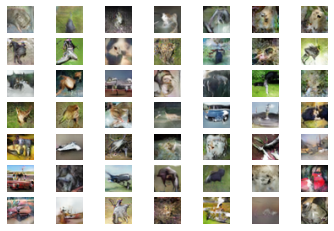

In [16]:
from tensorflow.keras.models import load_model

# Load the generator model
generator = load_model('run-002/generator_model_200.h5')
latent_points = generate_latent_points(latent_dim, n_samples)  # latent_dim should match your model's expected input
# Generate images
generated_images = generator.predict(latent_points)
show_generated_images(generated_images)
    